Problem Statement: Create a research and summarization agent using LangGraph

Packages

In [2]:
!pip install langgraph langchain langchain-openai tiktoken tavily-python requests beautifulsoup4 markitdown langchain-community faiss-cpu
# For Chroma instead of FAISS:
# !pip install chromadb

API Keys

In [3]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


In [4]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


In [5]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

Import

In [6]:
from __future__ import annotations

import os
import re
import time
from typing import Any, Dict, List, Optional, Literal, TypedDict

# LangGraph & LangChain
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from IPython.display import Image

# Vector store (FAISS) for RAG
from langchain_community.vectorstores import FAISS
from langchain.docstore.document import Document

# Web tools
from tavily import TavilyClient
import requests
from bs4 import BeautifulSoup
from markitdown import MarkItDown

In [7]:
OPENAI_MODEL = os.getenv("OPENAI_MODEL", "gpt-4.1-mini")     # strong, tool-capable, economical
EMBED_MODEL  = os.getenv("EMBED_MODEL", "text-embedding-3-small")

RAG_TOP_K = 4
WEB_TOP_K = 5

Sample Knowledge Base (RAG)

In [10]:
SAMPLE_RAG_DOCS = [
    Document(page_content="LangGraph is a library for building stateful, multi-actor LLM applications using graphs.", metadata={"source": "kb:langgraph_intro"}),
    Document(page_content="RAG stands for Retrieval Augmented Generation, combining vector search with generation to ground answers.", metadata={"source": "kb:rag_basics"}),
    Document(page_content="Web research is useful for up-to-date information such as current events, product prices, and breaking news.", metadata={"source": "kb:web_research"}),
]

LLM, Embeddings and VectorStore

In [11]:
llm = ChatOpenAI(model=OPENAI_MODEL, temperature=0.2)
embeddings = OpenAIEmbeddings(model=EMBED_MODEL)
vectorstore = FAISS.from_documents(SAMPLE_RAG_DOCS, embeddings)


/tmp/ipython-input-3158377705.py:2: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(model=EMBED_MODEL)


Graph State

In [12]:
class GraphState(TypedDict):
    query: str
    route: Optional[Literal["WEB", "RAG", "LLM"]]
    web_results: List[Dict[str, Any]]
    rag_results: List[Dict[str, Any]]
    llm_answer: Optional[str]
    final_answer: Optional[str]
    messages: List[Any]   # chat history

Router Agent

In [13]:

ROUTER_SYSTEM = SystemMessage(content=(
    "You are a router. Decide the best route for the user's query: 'WEB', 'RAG', or 'LLM'.\n"
    "Rules:\n"
    "- If the query asks for up-to-date info (contains words like latest, current, today, now, news, 202*, price, schedule), choose WEB.\n"
    "- If the query is clearly about the provided knowledge base or internal docs, choose RAG.\n"
    "- Otherwise choose LLM.\n"
    "Reply with just one token: WEB or RAG or LLM."
))

ROUTER_WEB_REGEX = re.compile(r"\b(latest|current|today|now|news|202\d|price|schedule|stock|live|update)\b", re.I)
RAG_HINT_REGEX   = re.compile(r"\b(knowledge\s*base|kb|from\s+docs?|according\s+to\s+our\s+data|internal)\b", re.I)

def router_agent(state: GraphState) -> GraphState:
    q = state["query"]

    # heuristic
    if ROUTER_WEB_REGEX.search(q):
        route = "WEB"
    elif RAG_HINT_REGEX.search(q):
        route = "RAG"
    else:
        # LLM fallback
        msgs = [ROUTER_SYSTEM, HumanMessage(content=q)]
        try:
            out = llm.invoke(msgs)
            cand = out.content.strip().upper()
            route = "WEB" if "WEB" in cand else ("RAG" if "RAG" in cand else "LLM")
        except Exception:
            route = "LLM"

    return {**state, "route": route}


Web Research Agent

In [14]:
def tavily_search(query: str, k: int = WEB_TOP_K) -> List[Dict[str, Any]]:
    api_key = os.getenv("TAVILY_API_KEY")
    if not api_key:
        return []
    tv = TavilyClient(api_key=api_key)
    res = tv.search(query=query, max_results=k)
    results = []
    for item in res.get("results", [])[:k]:
        results.append({
            "url": item.get("url"),
            "title": item.get("title"),
            "content": item.get("content"),
        })
    return results

def simple_scrape(url: str) -> Dict[str, Any]:
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
        }
        r = requests.get(url, headers=headers, timeout=15)
        r.raise_for_status()
        soup = BeautifulSoup(r.text, "html.parser")
        title = (soup.title.text.strip() if soup.title else url)
        text = "\n".join([p.get_text(" ", strip=True) for p in soup.find_all("p")])
        return {"url": url, "title": title, "content": text[:5000]}
    except Exception:
        return {"url": url, "title": url, "content": ""}

def markitdown_fetch(urls: List[str]) -> List[Dict[str, Any]]:
    md = MarkItDown()
    out: List[Dict[str, Any]] = []
    for u in urls:
        try:
            res = md.convert(u)
            title = (res.title or u).strip()
            text  = (res.text or res.markdown or "").strip()   # NOTE: res.content does not exist
            out.append({"url": u, "title": title, "content": text[:6000]})
        except Exception:
            out.append(simple_scrape(u))
    return out

def web_research_agent(state: GraphState) -> GraphState:
    q = state["query"]
    results = tavily_search(q, WEB_TOP_K)

    if not results:
        urls = re.findall(r"https?://\S+", q)
        if urls:
            results = markitdown_fetch(urls)
        else:
            results = [{"url": None, "title": "No web search configured", "content": "Set TAVILY_API_KEY or include URLs in the query."}]

    # Deduplicate & trim
    seen = set()
    cleaned: List[Dict[str, Any]] = []
    for r in results:
        key = (r.get("url"), r.get("title"))
        if key in seen:
            continue
        seen.add(key)
        snippet = (r.get("content") or "").strip()
        cleaned.append({"url": r.get("url"), "title": r.get("title"), "snippet": snippet[:1200]})
    return {**state, "web_results": cleaned}

RAG Agent

In [15]:
def rag_agent(state: GraphState) -> GraphState:
    q = state["query"]
    docs = vectorstore.similarity_search(q, k=RAG_TOP_K)
    results = [{"source": d.metadata.get("source"), "snippet": d.page_content} for d in docs]
    return {**state, "rag_results": results}

LLM Agent

In [16]:
LLM_SYSTEM = SystemMessage(content=(
    "You are a helpful expert assistant. Answer the user's question clearly and concisely using your internal knowledge."
))

def llm_agent(state: GraphState) -> GraphState:
    q = state["query"]
    msgs = [LLM_SYSTEM] + state.get("messages", []) + [HumanMessage(content=q)]
    out = llm.invoke(msgs)
    new_messages = state.get("messages", []) + [HumanMessage(content=q), AIMessage(content=out.content)]
    return {**state, "llm_answer": out.content, "messages": new_messages}

Summarization Agent

In [17]:
SUMM_SYSTEM = SystemMessage(content=(
    "You are a senior analyst. Synthesize all available evidence into a structured markdown answer.\n"
    "Sections to include when relevant: Answer, Key Points, Sources.\n"
    "- If web_results exist, cite them by title with the URL.\n"
    "- If rag_results exist, cite them by their 'source' labels.\n"
    "- If llm_answer exists, use it to fill gaps but prefer grounded info from web_results/RAG."
))

def summarization_agent(state: GraphState) -> GraphState:
    q = state["query"]
    web_bits = state.get("web_results", [])
    rag_bits = state.get("rag_results", [])
    llm_ans = state.get("llm_answer")

    context_parts = []
    if web_bits:
        for i, r in enumerate(web_bits, 1):
            context_parts.append(f"[WEB {i}] {r['title']} - {r.get('url')}\n{r['snippet']}")
    if rag_bits:
        for i, r in enumerate(rag_bits, 1):
            context_parts.append(f"[RAG {i}] {r['source']}\n{r['snippet']}")
    if llm_ans:
        context_parts.append(f"[LLM] {llm_ans}")

    context = "\n\n".join(context_parts) if context_parts else "(No external context)"

    prompt = [
        SUMM_SYSTEM,
        HumanMessage(content=(
            f"User Query:\n{q}\n\nContext:\n{context}\n\n"
            "Write a final, structured answer in markdown. Include a bullet list of sources."
        ))
    ]

    out = llm.invoke(prompt)
    final = out.content
    new_messages = state.get("messages", []) + [HumanMessage(content=q), AIMessage(content=final)]
    return {**state, "final_answer": final, "messages": new_messages}


Create LangGraph

In [18]:
def build_graph():
    graph = StateGraph(GraphState)

    # Nodes
    graph.add_node("router", router_agent)
    graph.add_node("web", web_research_agent)
    graph.add_node("rag", rag_agent)
    graph.add_node("llm", llm_agent)
    graph.add_node("summarize", summarization_agent)

    # Entry
    graph.set_entry_point("router")

    # Conditional routing
    def route_decider(state: GraphState) -> Literal["to_web", "to_rag", "to_llm"]:
        r = state.get("route", "LLM")
        if r == "WEB":
            return "to_web"
        if r == "RAG":
            return "to_rag"
        return "to_llm"

    graph.add_conditional_edges("router", route_decider, {
        "to_web": "web",
        "to_rag": "rag",
        "to_llm": "llm",
    })

    # Join to summarizer
    graph.add_edge("web", "summarize")
    graph.add_edge("rag", "summarize")
    graph.add_edge("llm", "summarize")

    # End
    graph.add_edge("summarize", END)

    return graph

Create Graph

In [22]:
app = build_graph().compile(checkpointer=MemorySaver())

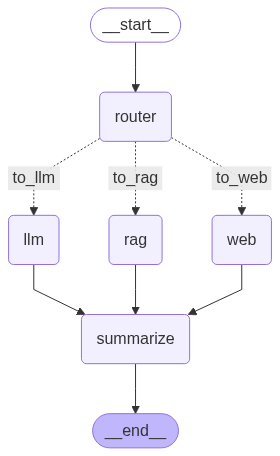

In [23]:
Image(app.get_graph().draw_mermaid_png())

Testing

In [26]:
def run_query(app, query: str, messages: Optional[List[Any]] = None):
    state: GraphState = {
        "query": query,
        "route": None,
        "web_results": [],
        "rag_results": [],
        "llm_answer": None,
        "final_answer": None,
        "messages": messages or [],
    }
    return app.invoke(state, config={"thread_id": "my_thread"})

def run_demo():
    tests = [
        # Expected: WEB
        "What are the latest updates about LangGraph in 2025?",
        # Expected: RAG (sample KB contains LangGraph basics)
        "Explain what LangGraph is from our knowledge base.",
        # Expected: LLM
        "Give a high-level difference between RAG and Web Research.",
    ]

    history: List[Any] = []
    results = []
    for q in tests:
        out = run_query(app, q, messages=history)
        results.append((q, out.get("route"), out.get("final_answer")))
        history = out.get("messages", history)
        time.sleep(0.2)
    return results

In [27]:
demo_results = run_demo()

In [28]:
demo_results

[('What are the latest updates about LangGraph in 2025?',
  'WEB',
  "# Latest Updates on LangGraph in 2025\n\n## Answer\n\nIn 2025, LangGraph has seen significant developments and improvements, particularly in its integration capabilities, tooling, and production readiness. Key updates include new feature rollouts for both LangGraph.js and LangGraph Python, enhanced workflow support, and better integration with LangChain's ecosystem. The platform is evolving towards more robust state-machine agents, interrupt-safe operations, and cloud deployment options, positioning it as a strong candidate for production AI applications.\n\nHowever, some challenges remain, such as stability issues with frequent updates in related frameworks like LangChain, and memory management concerns when handling large chains.\n\n## Key Points\n\n- **Feature Enhancements**: Recent releases have improved low-level workflows for LangGraph.js and LangGraph Python, enhancing developer experience and functionality.  